In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.signal import argrelextrema
from scipy.special import ndtr
from arch import arch_model

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    make_scorer, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, RocCurveDisplay, auc, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, precision_score, recall_score, 
)
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier, plot_importance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import phik
from phik.report import plot_correlation_matrix
import fAux
import mc_permutation
import detrendPrice 


import ta
from ta.trend import EMAIndicator 
global global_returns
global global_labels

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols):
        self.drop_cols = drop_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.drop_cols)
    
def get_data(ticker, start_date='1999-01-01', end_date=None, save_csv=False):
    os.makedirs("data", exist_ok=True)
    filename = f"data/{ticker.lower()}.csv"
    # if os.path.exists(filename):
    #     print(f"Data for {i} already exists, skipping download.")
    #     continue

    data = yf.download(ticker.upper(), start=start_date, end=end_date, auto_adjust=True)

    # Handle empty or failed download
    if data.empty:
        print(f"No data found for {ticker}")
        return pd.DataFrame()
    
    # Flatten column headers if it's a MultiIndex (e.g., from group_by='ticker')
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    
    data['Ticker'] = ticker.lower()
    data.index = pd.to_datetime(data.index)
    data.columns = [col.lower() for col in data.columns]


    if save_csv:
        data.to_csv(filename, index=False)
        print(f"Saved data for {ticker} to {filename}")
        
    return data


In [2]:
# spy = get_data('spy', end_date = '2025-07-20')
# nvda = get_data('nvda', end_date = '2025-07-20')
# pd.concat([nvda.head(),nvda.tail()])

In [3]:
# model for longing; trading at open tomorrow (t+1)
# based on today's data (ohlcv and more), decide whether to long tomorrow
# binary target: 1 if price reverts up (above the threshold e.g. gain over 2%) wihtin the next five trading days, 0 otherwise
def create_target_long(df, threshold=0.02, lookahead=5):
    """
    Label as 1 if max return over the next 'lookahead' days is >= threshold.
    Else, label as 0.
    """
    # df = df.reset_index().rename(columns={'Date': 'date'})
    df['price_tmrw'] = df['open'].shift(-1) # trade at open next day

    df['seq_index'] = range(len(df))
    future_max_list = []
    for i in df['seq_index']:
        if i + 1 + lookahead <= len(df):
            window = df['open'].iloc[i+1 : i+1+lookahead]
            future_max_list.append(window.max())
        else:
            future_max_list.append(np.nan)

    df['future_max'] = future_max_list

    df['future_return'] = (df['future_max'] - df['price_tmrw']) / df['price_tmrw']
    df['target_long'] = (df['future_return'] >= threshold).astype(int)
    df.drop(columns=['seq_index', 'price_tmrw', 'future_max', 'future_return'], inplace=True)
    return df



def feature_engineering(df): # for trading at open tomorrow
    # original_feats = df.columns

    # phase 1: add features thats fundamental to mean reversion trading with bollinger bands and rsi
    df['sma30'] = df['close'].rolling(30).mean()
    df['sma10'] = df['close'].rolling(10).mean()
    df['sma_diff'] = df['sma10'] - df['sma30']
    df['sma_slope'] = df['sma10'].diff()
    df['std30'] = df['close'].rolling(30).std()
    df['bollinger_upper'] = df['sma30'] + 2 * df['std30']
    df['bollinger_lower'] = df['sma30'] - 2 * df['std30']
    df['percent_b'] = (df['close'] - df['bollinger_lower']) / (df['bollinger_upper'] - df['bollinger_lower'])
    df['bollinger_z'] = (df['close'] - df['sma30']) / df['std30']
    df['price_near_lower_bb'] = (df['close'] <= df['bollinger_lower'] * 1.01).astype(int)

    df['rsi14'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()    
    df['prod_bollingerz_rsi'] = df['percent_b'] * df['rsi14']

    df['rsi_smooth'] = df['rsi14'].rolling(3).mean()
    # Detect local lows
    rsi_vals = df['rsi_smooth'].values
    local_lows = argrelextrema(rsi_vals, np.less, order=5)[0]

    df['rsi_local_low'] = 0
    df.iloc[local_lows, df.columns.get_loc('rsi_local_low')] = 1

    # phase 2: add other technical features  
    df['daily_return'] = df['open'].pct_change()
    df['rolling_volatility14'] = df['daily_return'].rolling(window=30).std()
    df['atr'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close']).average_true_range()

    # spy_ret5 (discard for now; if wanting to add add it from feature_engineering_add_macro)
    # spy_ret5 = df_spy['close'].pct_change(periods=5)
    # df = df.merge(spy_ret5.rename('spy_ret5'), left_index=True, right_index=True, how='left')

    # phase 3: more features!
    
    # 3.1 GARCH(1,1) on returns
    returns = df['close'].pct_change().dropna() * 100 # in percent
    am = arch_model(returns, vol='Garch', p=1, q=1)
    res = am.fit(disp='off')
    df['garch_vol'] = res.conditional_volatility # in percent

    # 3.2 tiem related features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['week'] = df.index.isocalendar().week
    df['dayofweek'] = df.index.dayofweek

    # df.dropna(inplace=True)
    # new_feats = [i for i in df.columns if i not in original_feats]
    return df



def feature_engineering_add_macro(df,etf:str):
    df_etf = get_data(etf, end_date = df.index.max())
    df_etf['sma10'] = df_etf['close'].rolling(10).mean()
    df_etf['sma20'] = df_etf['close'].rolling(20).mean()
    df_etf['sma50'] = df_etf['close'].rolling(50).mean()
    df_etf['sma200'] = df_etf['close'].rolling(200).mean()
    df_etf['trend_10_50'] = (df_etf['sma10'] > df_etf['sma50']).astype(int)
    df_etf['trend_20_50'] = (df_etf['sma20'] > df_etf['sma50']).astype(int)
    df_etf['trend_50_200'] = (df_etf['sma50'] > df_etf['sma200']).astype(int)
    df = df.merge(df_etf['trend_10_50'].rename(f'{etf}_trend_10_50'), left_index=True, right_index=True, how='left')
    df = df.merge(df_etf['trend_20_50'].rename(f'{etf}_trend_20_50'), left_index=True, right_index=True, how='left')
    df = df.merge(df_etf['trend_50_200'].rename(f'{etf}_trend_50_200'), left_index=True, right_index=True, how='left')
    return df



def plot_model_metrics(y_true, y_proba):
    y_pred = (y_proba >= 0.5).astype(int)
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[0], colorbar=False)

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_disp.plot(ax=axes[1])

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    pr_disp.plot(ax=axes[2])

    plt.tight_layout()
    plt.show()



def eval_pipe(X, y, pipe, n_split=5, predict_proba_threshold=0.5):
    '''
    for evaluations on train set, make sure X and y does not contain anything from the test set (future data), 
    and use n_split=5 for 5-fold time series cross-validation
    '''
    tscv = TimeSeriesSplit(n_splits=n_split)
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipe.fit(X_train, y_train)
        y_proba = pipe.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= predict_proba_threshold).astype(int)

        print(f'Fold {i+1}:\n{classification_report(y_test, y_pred)}')

        if i == 0:
            print('Fold 1 visualized below')
            plot_model_metrics(y_test, y_proba)

def pred_proba_to_signal(y_proba, threshold=0.5):
    """
    Convert predicted probabilities to binary signals.
    1 if probability >= threshold, else 0.
    returns a Series of signals.
    """
    return (y_proba >= threshold).astype(int)


def entry_exit(df, use_vol=None, take_profit=1, stop_loss=1): 
    '''
    FOR EACH INSTRUMENT (don't use the aggregated one that contains multiple tickers)
    takes in the X_test or ohlcv dataframe containing model signals,
    returns a df that contains entry and exit dates, prices, returns, and holding days
    use_vol: either 'atr' or 'garch_vol'
    take_profit and stop loss as percentage
    '''
    # if date as index
    if pd.api.types.is_datetime64_any_dtype(df.index): 
        df = df.reset_index().rename(columns={'Date': 'date'})

    trades = []
    i = 0
    n = len(df)
    if use_vol not in [None, 'atr', 'garch_vol']:
        raise ValueError("use_vol must be one of: None, 'atr' or 'garch_vol'")
    
    if use_vol == 'atr':
        multiplier = df['atr']
    elif use_vol == 'garch_vol':
        multiplier = df['garch_vol']
    else:
        multiplier = pd.Series(1, index=df.index)

    while i < n - 6:  # we need at least 5 days ahead, plus trading at open tomorrow
        if df['model_signal'].iloc[i] == 1:
            entry_date = df['date'].iloc[i+1]
            entry_price = df['open'].iloc[i+1]
            exit_price = None
            exit_date = None
            holding = None
            exit_reason = None

            for j in range(1, 6):  # check up to 5 days ahead
                if i + 1 + j >= n:
                    break

                next_price = df['open'].iloc[i + 1 + j]
                ret = (next_price - entry_price) / entry_price

                # Exit Conditions
                if ret >= take_profit * 0.01 * multiplier.iloc[i]:  # profit target
                    exit_price = next_price
                    exit_date = df['date'].iloc[i + 1 + j]
                    holding = j
                    exit_reason = 'profit_target'
                    break
                elif ret <= -stop_loss * 0.01 * multiplier.iloc[i]:  # stop loss
                    exit_price = next_price
                    exit_date = df['date'].iloc[i + 1 + j]
                    holding = j
                    exit_reason = 'stop_loss'
                    break
                elif df['open'].iloc[i + 1 + j] >= df['sma30'].iloc[i + 1 + j]:  # revert to SMA30
                    exit_price = next_price
                    exit_date = df['date'].iloc[i + 1 + j]
                    holding = j
                    exit_reason = 'revert_to_sma30'
                    break

            if exit_price is None:
                # Max holding (5th day)
                exit_price = df['open'].iloc[i + 1 + 5]
                exit_date = df['date'].iloc[i + 1 + 5]
                holding = 5

            trade_return = (exit_price - entry_price) / entry_price
            trades.append({
                'entry_date': entry_date,
                'exit_date': exit_date,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'return': trade_return,
                'holding_days': holding,
                'exit_reason': exit_reason
            })

            i = i + holding  # skip to the day after exit
        else:
            i += 1

    return pd.DataFrame(trades)



def backtest(X_test, model, proba_threshold = 0.5, use_vol=None, take_profit=1, stop_loss=1):
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f'max proba: {y_proba.max()}')
    signals = pred_proba_to_signal(y_proba, threshold=proba_threshold)
    X_test_signal = X_test.assign(model_signal=signals, y_proba=y_proba)

    trades = entry_exit(X_test_signal, use_vol, take_profit, stop_loss)

    total_holding_days = trades['holding_days'].sum()
    total_trading_days = len(X_test_signal)
    holding_time_percentage = total_holding_days/total_trading_days
    n_trades = len(trades)
    n_wins = len(trades[trades['return'] > 0])
    win_rate = n_wins/n_trades

    print(trades['exit_reason'].value_counts()) # 3 possible outcomes: profit_target, stop_loss, revert_to_sma30
    print('holding days spread:')
    print(trades['holding_days'].value_counts())
    print('---')
    print(f"total holding days: {total_holding_days} over {total_trading_days} trading days ({holding_time_percentage:.2%})")
    print(f'number of trades: {n_trades}')
    print(f"win rate: {win_rate:.2%}")
    return trades



def get_cagr(df):
    start_date = df['entry_date'].min()
    end_date = df['exit_date'].max()
    n_years = (end_date - start_date).days / 365.25
    capital = 1
    for r in df['return']:
        capital *= (1 + r)
    cagr = capital ** (1 / n_years) - 1
    return cagr

def get_sharpe(df_trades, X_test):
    ret_mean = df_trades['return'].mean()
    ret_std = df_trades['return'].std()
    n_trades = len(df_trades)
    total_trading_days = len(X_test)
    trades_per_year = (n_trades/total_trading_days) * 252
    return (ret_mean/ret_std) * np.sqrt(trades_per_year)


def check_return_stats(df):
    print(f"check return stats: \n {df['return'].describe()}")
    sns.histplot(df['return'])
    
    


In [ ]:
df = get_data('nvda',end_date='2025-07-17')
print(f'original cols (index is date): {df.columns}')
print(f'length of data: {len(df)}')
df = create_target_long(df)
df = feature_engineering(df)
df = feature_engineering_add_macro(df, 'spy')
df = feature_engineering_add_macro(df, 'qqq')
df.dropna(inplace=True)
print(f'shape: {df.shape}')
# pd.set_option('display.max_columns', None)
# df.tail()

[*********************100%***********************]  1 of 1 completed


original cols (index is date): Index(['close', 'high', 'low', 'open', 'volume', 'ticker'], dtype='object')
length of data: 6661


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

shape: (6628, 35)


In [5]:
X = df.drop(columns=['target_long','ticker'])
y = df['target_long']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(X.columns)

Index(['close', 'high', 'low', 'open', 'volume', 'sma30', 'sma10', 'sma_diff',
       'sma_slope', 'std30', 'bollinger_upper', 'bollinger_lower', 'percent_b',
       'bollinger_z', 'price_near_lower_bb', 'rsi14', 'prod_bollingerz_rsi',
       'rsi_smooth', 'rsi_local_low', 'daily_return', 'rolling_volatility14',
       'atr', 'garch_vol', 'year', 'month', 'week', 'dayofweek',
       'spy_trend_10_50', 'spy_trend_20_50', 'spy_trend_50_200',
       'qqq_trend_10_50', 'qqq_trend_20_50', 'qqq_trend_50_200'],
      dtype='object')


---

In [6]:
drop_feats = [
    # 'date',
    'high','low','sma30','sma10','std30',
    'bollinger_upper','bollinger_lower',
    'rsi_smooth',
]

ct = make_column_transformer(
    ('drop', drop_feats),  
    remainder='passthrough'  
)

pipe = Pipeline([
    ('ct', ct),
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])


/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1:
              precision    recall  f1-score   support

           0       0.41      0.42      0.42       377
           1       0.56      0.56      0.56       506

    accuracy                           0.50       883
   macro avg       0.49      0.49      0.49       883
weighted avg       0.50      0.50      0.50       883

Fold 1 visualized below


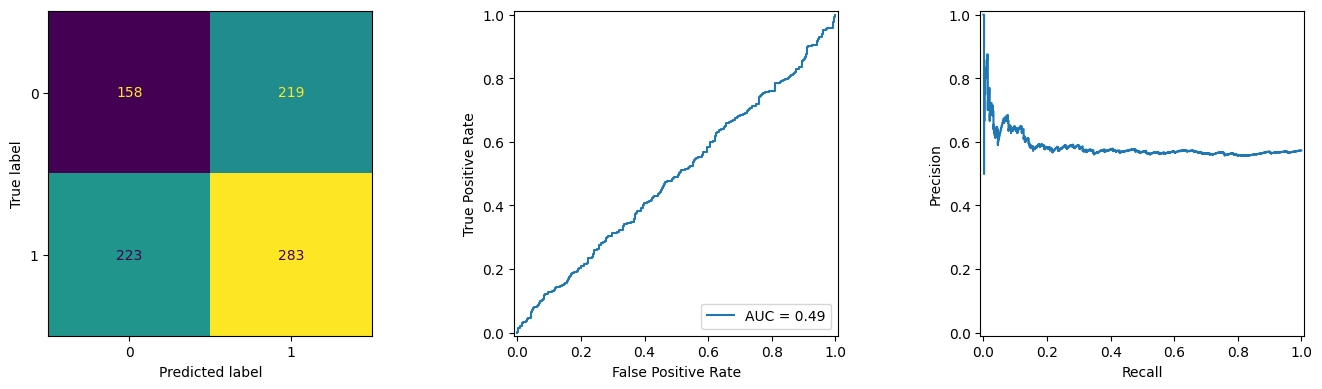

/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:54:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:54:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2:
              precision    recall  f1-score   support

           0       0.47      0.42      0.45       376
           1       0.60      0.65      0.62       507

    accuracy                           0.55       883
   macro avg       0.54      0.53      0.53       883
weighted avg       0.55      0.55      0.55       883

Fold 3:
              precision    recall  f1-score   support

           0       0.49      0.25      0.33       465
           1       0.46      0.70      0.55       418

    accuracy                           0.47       883
   macro avg       0.47      0.48      0.44       883
weighted avg       0.47      0.47      0.44       883



/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:54:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:54:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4:
              precision    recall  f1-score   support

           0       0.60      0.89      0.72       502
           1       0.59      0.20      0.30       381

    accuracy                           0.60       883
   macro avg       0.59      0.55      0.51       883
weighted avg       0.59      0.60      0.54       883

Fold 5:
              precision    recall  f1-score   support

           0       0.44      0.53      0.48       404
           1       0.53      0.44      0.48       479

    accuracy                           0.48       883
   macro avg       0.49      0.49      0.48       883
weighted avg       0.49      0.48      0.48       883



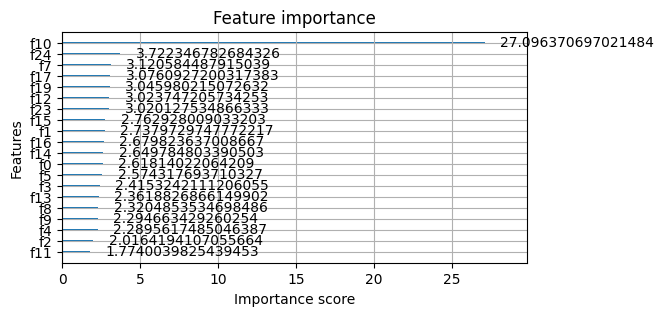

f0 → close
f1 → open
f2 → volume
f3 → sma_diff
f4 → sma_slope
f5 → percent_b
f6 → bollinger_z
f7 → price_near_lower_bb
f8 → rsi14
f9 → prod_bollingerz_rsi
f10 → rsi_local_low
f11 → daily_return
f12 → rolling_volatility14
f13 → atr
f14 → garch_vol
f15 → year
f16 → month
f17 → week
f18 → dayofweek
f19 → spy_trend_10_50
f20 → spy_trend_20_50
f21 → spy_trend_50_200
f22 → qqq_trend_10_50
f23 → qqq_trend_20_50
f24 → qqq_trend_50_200


In [18]:
eval_pipe(X_train, y_train, pipe, predict_proba_threshold=0.5)

# check feature importance
fig, ax = plt.subplots(figsize=(6,3)) 
xgb = pipe.named_steps['xgb']
# feature_names = pipe.named_steps['ct'].get_feature_names_out()
# xgb.get_booster().feature_names = feature_names
plot_importance(xgb, importance_type='gain', max_num_features=20, ax=ax)
plt.show()

feature_names = pipe.named_steps['ct'].get_feature_names_out()
# Optional: clean up prefix if using 'remainder__'
feature_names = [name.split('__')[-1] for name in feature_names]

# Print mapping
for i, name in enumerate(feature_names):
    print(f"f{i} → {name}")


In [8]:
# hyperparameter tuning
param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 300, 500],
    'xgb__subsample': [0.5, 0.7, 1.0],
    'xgb__colsample_bytree': [0.5, 0.7, 1.0]
}

rscv = RandomizedSearchCV(
    pipe,
    param_distributions=param_grid,
    n_iter=30,  # number of random combinations to try
    scoring='f1',  # or 'roc_auc', 'accuracy', etc.
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Run search
rscv.fit(X_train, y_train)

# Best model
print("Best Parameters:")
print(rscv.best_params_)

print("\nBest Score:")
print(rscv.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

Best Parameters:
{'xgb__subsample': 1.0, 'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 1.0}

Best Score:
0.4792495506833876


/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:54:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


max proba: 0.7963022589683533
exit_reason
profit_target      528
stop_loss          401
revert_to_sma30    259
Name: count, dtype: int64
holding days spread:
holding_days
1    1105
2      68
3      12
4       2
5       1
Name: count, dtype: int64
---
total holding days: 1290 over 1326 trading days (97.29%)
number of trades: 1188
win rate: 56.06%
---
cagr: 84.03%
sharpe: 1.4
---
check return stats: 
 count    1188.000000
mean        0.003346
std         0.036011
min        -0.158860
25%        -0.018422
50%         0.004292
75%         0.025213
max         0.275174
Name: return, dtype: float64


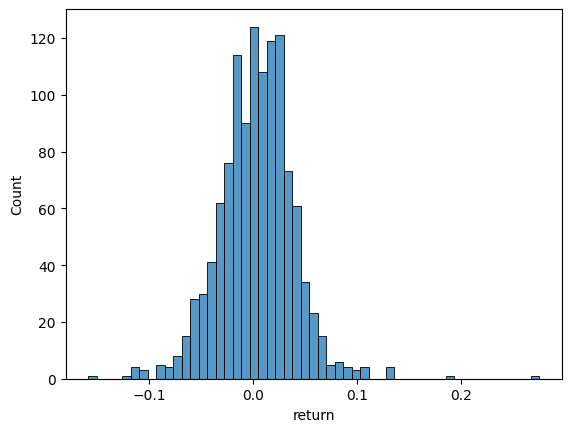

In [13]:
# backtest
trades_1 = backtest(X_test, rscv, proba_threshold = 0.5, use_vol = None, take_profit = 1, stop_loss = 1)
print('---')
print(f"cagr: {get_cagr(trades_1):.2%}")
print(f"sharpe: {get_sharpe(trades_1, X_test):.2}")
print('---')
check_return_stats(trades_1)

max proba: 0.7963022589683533
exit_reason
revert_to_sma30    804
stop_loss           54
profit_target       44
Name: count, dtype: int64
holding days spread:
holding_days
1    814
5     57
2     42
3     19
4     14
Name: count, dtype: int64
---
total holding days: 1296 over 1326 trading days (97.74%)
number of trades: 946
win rate: 58.03%
---
cagr: 84.14%
sharpe: 1.4
---
check return stats: 
 count    946.000000
mean       0.004164
std        0.039183
min       -0.158860
25%       -0.013604
50%        0.004182
75%        0.024672
max        0.275174
Name: return, dtype: float64


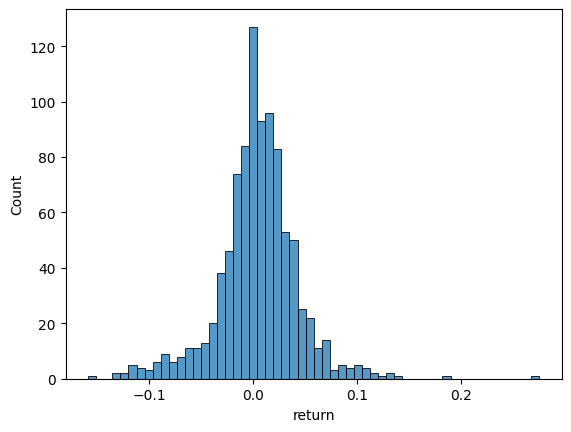

In [14]:
# backtest 2: try using garch volatility as multiplier and 2% profit and stop loss
trades_2 = backtest(X_test, rscv, proba_threshold = 0.5, use_vol = 'garch_vol', take_profit = 2, stop_loss = 2)
print('---')
print(f"cagr: {get_cagr(trades_2):.2%}")
print(f"sharpe: {get_sharpe(trades_2, X_test):.2}")
print('---')
check_return_stats(trades_2)

### comment
- medium SHARPE in the two examples above

max proba: 0.7963022589683533
exit_reason
revert_to_sma30    44
profit_target      22
stop_loss           2
Name: count, dtype: int64
holding days spread:
holding_days
1    51
2     8
5     7
4     4
3     4
Name: count, dtype: int64
---
total holding days: 130 over 1326 trading days (9.80%)
number of trades: 74
win rate: 82.43%
---
cagr: 62.23%
sharpe: 3.3
---
check return stats: 
 count    74.000000
mean      0.035720
std       0.040260
min      -0.080957
25%       0.011136
50%       0.034483
75%       0.053609
max       0.135206
Name: return, dtype: float64


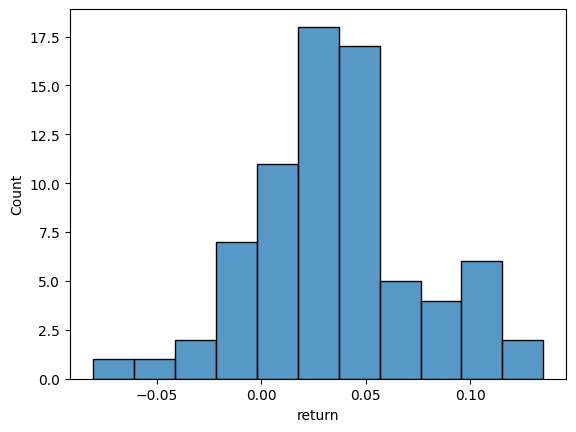

In [15]:
# backtest 3: trade more cautiously
# proba threshold set to 0.7
# use a 1.5 to 1 profit loss ratio
trades_3 = backtest(X_test, rscv, proba_threshold = 0.7, use_vol = 'garch_vol', take_profit = 1.5, stop_loss = 1)
print('---')
print(f"cagr: {get_cagr(trades_3):.2%}")
print(f"sharpe: {get_sharpe(trades_3, X_test):.2}")
print('---')
check_return_stats(trades_3)

---
# WRC & Monte Carlo

White Reality Check p-value: 0.4840
Monte Carlo p-value: 0.0100


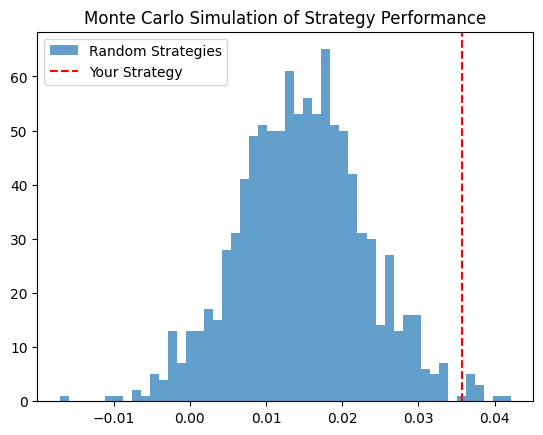

In [25]:
from statsmodels.tsa.stattools import acf

def white_reality_check(returns, n_bootstraps=1000, block_size=5):
    """
    Returns: array of strategy returns (percent, not log)
    n_bootstraps: number of bootstrap samples
    block_size: block size for stationary bootstrap (to preserve autocorrelation)
    """
    T = len(returns)
    actual_mean = np.mean(returns)
    bootstrapped_means = []

    for _ in range(n_bootstraps):
        # Stationary block bootstrap
        i = 0
        bootstrapped = []
        while i < T:
            start = np.random.randint(0, T)
            block_len = np.random.geometric(1/block_size)
            block = returns[start:start+block_len]
            bootstrapped.extend(block)
            i += block_len
        bootstrapped = bootstrapped[:T]
        bootstrapped_means.append(np.mean(bootstrapped))

    p_value = np.mean([bm >= actual_mean for bm in bootstrapped_means])
    return p_value, actual_mean, bootstrapped_means

pval, actual_avg, dist = white_reality_check(trades_3['return'].values)
print(f"White Reality Check p-value: {pval:.4f}")


# ---

def monte_carlo_simulation(df, n_simulations=1000, lookahead=5):
    simulated_returns = []
    n = len(df)
    for _ in range(n_simulations):
        returns = []
        for _ in range(len(trades_3)):  # simulate same number of trades
            i = np.random.randint(0, n - lookahead - 1)
            try:
                entry = df['open'].iloc[i+1]
                exit = df['open'].iloc[i+1+lookahead]
                ret = (exit - entry) / entry
                returns.append(ret)
            except IndexError:
                continue  # skip if out of bounds
        if returns:  # avoid empty list
            simulated_returns.append(np.mean(returns))
    return simulated_returns


df_mc = X_test[['open']]
sim_returns = monte_carlo_simulation(df_mc)
actual_mean = trades_3['return'].mean()
p_value_mc = np.mean([r >= actual_mean for r in sim_returns])
print(f'Monte Carlo p-value: {p_value_mc:.4f}')


plt.hist(sim_returns, bins=50, alpha=0.7, label='Random Strategies')
plt.axvline(actual_mean, color='red', linestyle='--', label='Your Strategy')
plt.title('Monte Carlo Simulation of Strategy Performance')
plt.legend()
plt.show()
